In [1]:
# -*- coding: utf-8 -*-
"""
ryPrepareDataset00.py
ryPrepareDataset02.py
+ryAddSilenceInTrain(allFiles)
"internet" ==> sd_GSCmdV2/ ==> fn= 'ryGsc_sil1.npz'

#--------------------
# ryPrepareDataset03.py
#--------------------

"""
# In[]
from tqdm import tqdm
import requests
import math
import os
import tarfile
import numpy as np
import librosa
import pandas as pd
import time

#import audioUtils

def _downloadFile(url, fName):
    # Streaming, so we can iterate over the response.
    r = requests.get(url, stream=True)

    # Total size in bytes.
    total_size = int(r.headers.get('content-length', 0)); 
    block_size = 1024
    wrote = 0 
    print('Downloading {} into {}'.format(url, fName))
    with open(fName, 'wb') as f:
        for data in tqdm(r.iter_content(block_size), 
                         total= math.ceil(total_size//block_size) , 
                         unit=  'KB', 
                         unit_scale= True):
            
            wrote = wrote  + len(data)
            f.write(data)
    if total_size != 0 and wrote != total_size:
        print("ERROR, something went wrong")
        
def _extractTar(fname, folder):
    print('Extracting {} into {}'.format(fname, folder))
    if (fname.endswith("tar.gz")):
        tar = tarfile.open(fname, "r:gz")
        tar.extractall(path=folder)
        tar.close()
    elif (fname.endswith("tar")):
        tar = tarfile.open(fname, "r:")
        tar.extractall(path=folder)
        tar.close()      

def _DownloadGoogleSpeechCmdV2(basePath, forceDownload= False):
    """
    Downloads Google Speech commands dataset version 2
    """
    #global basePath
    
    dataUrl01= 'http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz'
    dataUrl02= 'http://download.tensorflow.org/data/speech_commands_test_set_v0.02.tar.gz'
    
    if os.path.isdir(basePath) and not forceDownload:
        print('Google Speech commands dataset version 2 already exists. Skipping download.')
    else:
        if not os.path.exists(basePath):
            os.makedirs(basePath)
        trainFiles= dataUrl01
        testFiles=  dataUrl02
        _downloadFile(testFiles, basePath+'test.tar.gz')
        _downloadFile(trainFiles, basePath+'train.tar.gz')
    
    #extract files
    if not os.path.isdir(basePath+"test/"):
        _extractTar(basePath+'test.tar.gz', basePath+'test/')
        
    if not os.path.isdir(basePath+"train/"):
        _extractTar(basePath+'train.tar.gz', basePath+'train/')
        
#--------------------------        
basePath= '../ryDatasets/gscV2/'
_DownloadGoogleSpeechCmdV2(basePath, forceDownload= False)  
 


# In[]
#read split from files and all files in folders
testWAVs= pd.read_csv(basePath+'train/testing_list.txt', sep=" ", header=None)[0].tolist()
valWAVs=  pd.read_csv(basePath+'train/validation_list.txt', sep=" ", header=None)[0].tolist()


testWAVs= [os.path.join(basePath+'train/', f) for f in testWAVs if f.endswith('.wav')]
valWAVs=  [os.path.join(basePath+'train/', f) for f in valWAVs if f.endswith('.wav')]


allWAVs= []
for root, dirs, files in os.walk(basePath+'train/'):
    allWAVs+= [root+'/'+f  for f in files if f.endswith('.wav')]

trainWAVs= list( set(allWAVs)-set(valWAVs)-set(testWAVs) )

info= '{},{},{},{}'.format(
        len(testWAVs), 
        len(valWAVs), 
        len(trainWAVs), 
        len(allWAVs))
print(info)
# In[]

ryGscDict=  {   'unknown' : 0, 'silence' : 0, 
                '_unknown_' : 0, '_silence_' : 0, 
                '_background_noise_' : 0,
                
                'one' : 1, 'two' : 2, 'three' : 3, 'four' : 4, 'five' : 5,
                'six' : 6, 'seven' : 7,  'eight' : 8, 'nine' : 9,  'zero' : 10,                

                'yes' : 11, 'no' : 12, 
                'go' : 13, 'stop' :14, 
                'on' : 15,  'off' :16, 

                'up' : 17, 'down' : 18, 
                'left' : 19, 'right' : 20,
                'forward':21, 'backward':22, 
                
                'marvin':23,'sheila':24, 
                'dog':25,   'cat':26, 
                'bird':27,  'bed':28, 
                'happy':29, 'house':30,
                'learn':31, 'follow':32,  
                 'tree':33, 'visual':34, 
                 'wow':35}

# list(ryGscCategs.keys())
ryGscList=[ 
 '_silence_',
 'one',  'two', 'three', 'four', 'five',
 'six', 'seven', 'eight', 'nine', 'zero',
 'yes', 'no',
 'go', 'stop',
 'on', 'off',
 'up', 'down',
 'left', 'right',
 'forward', 'backward',
 'marvin', 'sheila',
 'dog', 'cat',
 'bird', 'bed',
 'happy', 'house',
 'learn', 'follow',
 'tree', 'visual',
 'wow'
 ]

def _getFileCategory(file, catDict):
    """
    Receives a file with name sd_GSCmdV2/train/<cat>/<filename> and returns an integer that is catDict[cat]
    """
    categ = os.path.basename(os.path.dirname(file))
    return catDict.get(categ,0)

#get categories
testWAVlabels= [_getFileCategory(f, ryGscDict) for f in testWAVs]
valWAVlabels=  [_getFileCategory(f, ryGscDict) for f in valWAVs]
trainWAVlabels=[_getFileCategory(f, ryGscDict) for f in trainWAVs]

#background noise should be used for validation as well
bgWAVs= [trainWAVs[i] 
         for i in range(len(trainWAVlabels)) 
         if trainWAVlabels[i]==ryGscDict['silence']]
bgWAVlabels= [ryGscDict['_silence_'] for i in range(len(bgWAVs))]


# In[]
#build dictionaries
testWAVlabelsDict=  dict(zip(testWAVs, testWAVlabels))
valWAVlabelsDict=   dict(zip(valWAVs, valWAVlabels))
trainWAVlabelsDict= dict(zip(trainWAVs, trainWAVlabels))

bgWAVlabelsDict=    dict(zip(bgWAVs, bgWAVlabels))


#info dictionary
trainInfo= {'files': trainWAVs, 'labels' : trainWAVlabelsDict}
valInfo=   {'files': valWAVs,   'labels' : valWAVlabelsDict}
testInfo=  {'files': testWAVs,  'labels' : testWAVlabelsDict}
bgInfo=    {'files': bgWAVs,    'labels' : bgWAVlabelsDict}

gscInfo= {'train': trainInfo, 
          'val':   valInfo, 
          'test':  testInfo,
          'bg':    bgInfo}    

info= [(s, len(gscInfo[s]['files'])) for s in gscInfo.keys()] 
print(info)

# In[]
# In[]
import librosa
import pylab as pl

#import sounddevice as sd

# Data Visualization for 'train'
s='train'

fn= list(gscInfo[s]['labels'].keys())[-1]
x, sr= librosa.load(fn, sr=None)

print(f'x.shape= {x.shape}, sr= {sr}')

pl.figure(figsize=(10,10))
for i in range(100):
    
    fn= list(gscInfo[s]['labels'].keys())[i]
    x, sr= librosa.load(fn, sr=None)
    
    #sd.play(x,sr)

    
    label= list(gscInfo[s]['labels'].values())[i]
    
    c= ryGscList[label]
    
    pl.subplot(10,10,i+1)
    pl.title(c)
    pl.plot(x)
    
    #sd.wait()

# In[]
    
# Data Visualization for 'bg'
    
s='bg'

fn= list(gscInfo[s]['labels'].keys())[-1]
x, sr= librosa.load(fn, sr=None)

print(f'x.shape= {x.shape}, sr= {sr}')


nWav= len(gscInfo[s]['labels'].keys())

pl.figure(figsize=(10,10))
for i in range(nWav):
    
    fn= list(gscInfo[s]['labels'].keys())[i]
    x, sr= librosa.load(fn, sr=None)
    
    #sd.play(x,sr)
    
    label= list(gscInfo[s]['labels'].values())[i]
    
    c= ryGscList[label]
    
    pl.subplot(nWav,1,i+1)
    pl.title(c)
    pl.plot(x)
    
    #sd.wait()
# In[]
# In[]
# load all data into memory
# 有些檔案長度不為 1 sec，要 normalize 成 1 sec= 16000
def ryLengthNormalize(x, length=16000):
    #curX could be bigger or smaller than self.dim
    if len(x) == length:
        X= x
        #print('Same dim')
    elif len(x) > length: #bigger
        #we can choose any position in curX-self.dim
        randPos= np.random.randint(len(x)-length)
        X= x[randPos:randPos+length]
        #print('File dim bigger')
    else: #smaller
        randPos= np.random.randint(length-len(x))
        
        X= np.random.random(length)*1e-10
        
        X[randPos:randPos+len(x)]= x
        #print('File dim smaller')
    return X


# In[]
    
xLL= []
yLL= []

for s in ['val', 'test', 'train']:
    aL=  gscInfo[s]['files']
    xL= []
    for fn in tqdm(aL):
        x, sr= librosa.load(fn, sr= None)
        x= ryLengthNormalize(x)
        xL += [x]
    xL= np.vstack(xL)
    xLL += [xL]
    
    yL=  list(gscInfo[s]['labels'].values())
    yL= np.array(yL)
    yLL += [yL]
    
x_val, x_test, x_train= xLL
y_val, y_test, y_train= yLL


# In[]
# 針對 silence, bg, 長度太長，把他們切成 數個 1秒 sound
bgFiles= gscInfo['bg']['files']

def rySplitSilenceIn1SecSoundList(bgFiles):
    
    noiseL= [librosa.load(fn, sr=None)[0] for fn in bgFiles]
       
    n=0
    silenceL= []
    for x in noiseL:
        t=0
        while (t+1)*16000 < x.size:
            x1sec= x[t*16000:(t+1)*16000]
            silenceL += [x1sec]
            t+=1
        n+=1

    return silenceL

silenceL= rySplitSilenceIn1SecSoundList(bgFiles)
x_bg= silenceL= np.vstack(silenceL)
y_bg= np.zeros(len(silenceL))

x_trainWithSil=  np.vstack((x_train, x_bg))
y_trainWithSil=  np.concatenate((y_train, y_bg))

# In[]
assert x_train.shape[0]        == y_train.shape[0]
assert x_val.shape[0]          == y_val.shape[0]
assert x_test.shape[0]         == y_test.shape[0]
assert x_trainWithSil.shape[0] == y_trainWithSil.shape[0]

x_trainWithSil= x_trainWithSil.astype('float32')
x_test=         x_test.astype('float32')
x_val=          x_val.astype('float32')

y_trainWithSil= y_trainWithSil.astype('int')
y_test=         y_test.astype('int')
y_val=          y_val.astype('int')


# In[]
import time

t0= time.time()
import os

#basePath= '../ryDatasets/gscV2/'

fn= 'gscV2_data.npz'
if not os.path.isfile(basePath+fn):
    np.savez_compressed(
        basePath+fn, 
        x_trainWithSil=    x_trainWithSil, 
        y_trainWithSil=    y_trainWithSil,
        x_val=      x_val,
        y_val=      y_val,
        x_test=     x_test, 
        y_test=     y_test,
        )

dt= time.time()-t0
print(f'np.savez_compressed(), fn= {fn}, dt(sec)= {dt:.2f}')

# np.savez_compressed(), dt(sec)= 778.8924231529236

# In[]
# In[]
# In[]
# In[]
# In[]
if __name__=='__main__':
    
    t0= time.time()
    
    #basePath= '../ryDatasets/gscV2/'
    fn= 'gscV2_data.npz'
    z= np.load(basePath+fn)
    
    x_train=    z['x_trainWithSil']    
    y_train=    z['y_trainWithSil']    
    x_val=      z['x_val']      
    y_val=      z['y_val']
    x_test=     z['x_test']     
    y_test=     z['y_test']     
    
    
    dt= time.time()-t0
    print(f'np.load({basePath+fn}), dt(sec)= {dt:.3f}')



# In[]


Google Speech commands dataset version 2 already exists. Skipping download.
11005,9981,84849,105835
[('train', 84849), ('val', 9981), ('test', 11005), ('bg', 6)]
x.shape= (16000,), sr= 16000
x.shape= (980062,), sr= 16000


100%|████████████████████████████████████████████████████████████████████████████| 84849/84849 [26:29<00:00, 53.37it/s]


np.savez_compressed(), fn= gscV2_data.npz, dt(sec)= 0.00
np.load(../ryDatasets/gscV2/gscV2_data.npz), dt(sec)= 31.061


.... z= np.load(gscV2_data.npz) will train into ryModel.hdf5
.... get_all_fearure() .... 
XL.shape=(11005, 125, 128)
tf.signal.stft, 執行時間 dt= 4.429272890090942
XL.shape=(9981, 125, 128)
tf.signal.stft, 執行時間 dt= 1.3035130500793457
XL.shape=(85245, 125, 128)
tf.signal.stft, 執行時間 dt= 26.62716579437256
... get_all_fearure() ... dt(sec)= 32.929
.... normalize() ....
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 125, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 125, 128, 8)       2056      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 8)         0         
___________________________

85000/85245 [============================>.] - ETA: 10:05 - loss: 3.7266 - accuracy: 0.032 - ETA: 5:08 - loss: 3.6738 - accuracy: 0.039 - ETA: 3:29 - loss: 3.6307 - accuracy: 0.04 - ETA: 2:40 - loss: 3.6171 - accuracy: 0.04 - ETA: 2:10 - loss: 3.6059 - accuracy: 0.04 - ETA: 1:50 - loss: 3.5962 - accuracy: 0.04 - ETA: 1:36 - loss: 3.5846 - accuracy: 0.04 - ETA: 1:25 - loss: 3.5815 - accuracy: 0.04 - ETA: 1:17 - loss: 3.5774 - accuracy: 0.04 - ETA: 1:10 - loss: 3.5699 - accuracy: 0.04 - ETA: 1:05 - loss: 3.5637 - accuracy: 0.04 - ETA: 1:00 - loss: 3.5558 - accuracy: 0.05 - ETA: 56s - loss: 3.5449 - accuracy: 0.0557 - ETA: 53s - loss: 3.5380 - accuracy: 0.056 - ETA: 50s - loss: 3.5271 - accuracy: 0.059 - ETA: 47s - loss: 3.5152 - accuracy: 0.062 - ETA: 45s - loss: 3.5034 - accuracy: 0.065 - ETA: 43s - loss: 3.4923 - accuracy: 0.067 - ETA: 41s - loss: 3.4770 - accuracy: 0.071 - ETA: 40s - loss: 3.4651 - accuracy: 0.074 - ETA: 38s - loss: 3.4531 - accuracy: 0.076 - ETA: 37s - loss: 3.4429 -

85000/85245 [============================>.] - ETA: 16s - loss: 1.3658 - accuracy: 0.632 - ETA: 16s - loss: 1.4316 - accuracy: 0.600 - ETA: 15s - loss: 1.4510 - accuracy: 0.586 - ETA: 15s - loss: 1.4475 - accuracy: 0.586 - ETA: 15s - loss: 1.4603 - accuracy: 0.582 - ETA: 15s - loss: 1.4654 - accuracy: 0.574 - ETA: 15s - loss: 1.4846 - accuracy: 0.567 - ETA: 14s - loss: 1.4797 - accuracy: 0.567 - ETA: 14s - loss: 1.4607 - accuracy: 0.571 - ETA: 14s - loss: 1.4431 - accuracy: 0.575 - ETA: 14s - loss: 1.4555 - accuracy: 0.572 - ETA: 14s - loss: 1.4687 - accuracy: 0.569 - ETA: 14s - loss: 1.4654 - accuracy: 0.570 - ETA: 14s - loss: 1.4643 - accuracy: 0.571 - ETA: 14s - loss: 1.4658 - accuracy: 0.571 - ETA: 14s - loss: 1.4649 - accuracy: 0.571 - ETA: 14s - loss: 1.4664 - accuracy: 0.571 - ETA: 14s - loss: 1.4612 - accuracy: 0.573 - ETA: 13s - loss: 1.4544 - accuracy: 0.574 - ETA: 13s - loss: 1.4520 - accuracy: 0.575 - ETA: 13s - loss: 1.4499 - accuracy: 0.576 - ETA: 13s - loss: 1.4441 - acc

85000/85245 [============================>.] - ETA: 14s - loss: 0.9657 - accuracy: 0.714 - ETA: 15s - loss: 0.9369 - accuracy: 0.718 - ETA: 15s - loss: 0.9564 - accuracy: 0.719 - ETA: 15s - loss: 0.9454 - accuracy: 0.722 - ETA: 15s - loss: 0.9398 - accuracy: 0.724 - ETA: 15s - loss: 0.9678 - accuracy: 0.715 - ETA: 15s - loss: 0.9667 - accuracy: 0.714 - ETA: 15s - loss: 0.9750 - accuracy: 0.710 - ETA: 15s - loss: 0.9796 - accuracy: 0.708 - ETA: 14s - loss: 0.9820 - accuracy: 0.709 - ETA: 14s - loss: 0.9784 - accuracy: 0.709 - ETA: 14s - loss: 0.9731 - accuracy: 0.712 - ETA: 14s - loss: 0.9729 - accuracy: 0.712 - ETA: 14s - loss: 0.9676 - accuracy: 0.714 - ETA: 14s - loss: 0.9641 - accuracy: 0.715 - ETA: 14s - loss: 0.9613 - accuracy: 0.715 - ETA: 14s - loss: 0.9592 - accuracy: 0.716 - ETA: 14s - loss: 0.9569 - accuracy: 0.718 - ETA: 14s - loss: 0.9575 - accuracy: 0.717 - ETA: 14s - loss: 0.9593 - accuracy: 0.716 - ETA: 14s - loss: 0.9563 - accuracy: 0.717 - ETA: 13s - loss: 0.9616 - acc

85000/85245 [============================>.] - ETA: 15s - loss: 0.7209 - accuracy: 0.786 - ETA: 15s - loss: 0.7550 - accuracy: 0.766 - ETA: 15s - loss: 0.7982 - accuracy: 0.753 - ETA: 15s - loss: 0.8191 - accuracy: 0.750 - ETA: 15s - loss: 0.8044 - accuracy: 0.754 - ETA: 15s - loss: 0.8061 - accuracy: 0.755 - ETA: 15s - loss: 0.7984 - accuracy: 0.757 - ETA: 14s - loss: 0.7959 - accuracy: 0.759 - ETA: 14s - loss: 0.7935 - accuracy: 0.759 - ETA: 14s - loss: 0.8001 - accuracy: 0.760 - ETA: 14s - loss: 0.8084 - accuracy: 0.757 - ETA: 14s - loss: 0.8036 - accuracy: 0.759 - ETA: 14s - loss: 0.7990 - accuracy: 0.760 - ETA: 14s - loss: 0.7921 - accuracy: 0.762 - ETA: 14s - loss: 0.7959 - accuracy: 0.761 - ETA: 14s - loss: 0.7952 - accuracy: 0.762 - ETA: 14s - loss: 0.7959 - accuracy: 0.762 - ETA: 14s - loss: 0.7942 - accuracy: 0.763 - ETA: 14s - loss: 0.7887 - accuracy: 0.765 - ETA: 14s - loss: 0.7849 - accuracy: 0.766 - ETA: 13s - loss: 0.7794 - accuracy: 0.768 - ETA: 13s - loss: 0.7745 - acc

85000/85245 [============================>.] - ETA: 15s - loss: 0.8212 - accuracy: 0.764 - ETA: 15s - loss: 0.7178 - accuracy: 0.784 - ETA: 15s - loss: 0.7153 - accuracy: 0.784 - ETA: 15s - loss: 0.6879 - accuracy: 0.795 - ETA: 15s - loss: 0.6910 - accuracy: 0.792 - ETA: 15s - loss: 0.7036 - accuracy: 0.790 - ETA: 15s - loss: 0.6950 - accuracy: 0.789 - ETA: 14s - loss: 0.6818 - accuracy: 0.794 - ETA: 14s - loss: 0.6838 - accuracy: 0.793 - ETA: 14s - loss: 0.6902 - accuracy: 0.791 - ETA: 14s - loss: 0.6903 - accuracy: 0.791 - ETA: 14s - loss: 0.6906 - accuracy: 0.791 - ETA: 14s - loss: 0.6789 - accuracy: 0.794 - ETA: 14s - loss: 0.6743 - accuracy: 0.796 - ETA: 14s - loss: 0.6733 - accuracy: 0.797 - ETA: 14s - loss: 0.6732 - accuracy: 0.796 - ETA: 14s - loss: 0.6760 - accuracy: 0.796 - ETA: 14s - loss: 0.6740 - accuracy: 0.797 - ETA: 14s - loss: 0.6716 - accuracy: 0.798 - ETA: 13s - loss: 0.6700 - accuracy: 0.797 - ETA: 13s - loss: 0.6670 - accuracy: 0.799 - ETA: 13s - loss: 0.6724 - acc

85000/85245 [============================>.] - ETA: 15s - loss: 0.5688 - accuracy: 0.828 - ETA: 15s - loss: 0.5559 - accuracy: 0.828 - ETA: 15s - loss: 0.5671 - accuracy: 0.828 - ETA: 15s - loss: 0.5481 - accuracy: 0.835 - ETA: 15s - loss: 0.5495 - accuracy: 0.834 - ETA: 15s - loss: 0.5483 - accuracy: 0.833 - ETA: 15s - loss: 0.5602 - accuracy: 0.830 - ETA: 15s - loss: 0.5650 - accuracy: 0.828 - ETA: 14s - loss: 0.5730 - accuracy: 0.825 - ETA: 14s - loss: 0.5772 - accuracy: 0.824 - ETA: 14s - loss: 0.5715 - accuracy: 0.826 - ETA: 14s - loss: 0.5737 - accuracy: 0.825 - ETA: 14s - loss: 0.5736 - accuracy: 0.826 - ETA: 14s - loss: 0.5732 - accuracy: 0.825 - ETA: 14s - loss: 0.5709 - accuracy: 0.827 - ETA: 14s - loss: 0.5711 - accuracy: 0.827 - ETA: 14s - loss: 0.5746 - accuracy: 0.825 - ETA: 14s - loss: 0.5814 - accuracy: 0.823 - ETA: 14s - loss: 0.5810 - accuracy: 0.823 - ETA: 13s - loss: 0.5785 - accuracy: 0.824 - ETA: 13s - loss: 0.5790 - accuracy: 0.824 - ETA: 13s - loss: 0.5797 - acc

85000/85245 [============================>.] - ETA: 15s - loss: 0.5574 - accuracy: 0.826 - ETA: 15s - loss: 0.5618 - accuracy: 0.821 - ETA: 15s - loss: 0.5425 - accuracy: 0.831 - ETA: 15s - loss: 0.5250 - accuracy: 0.835 - ETA: 14s - loss: 0.5501 - accuracy: 0.831 - ETA: 14s - loss: 0.5562 - accuracy: 0.832 - ETA: 14s - loss: 0.5506 - accuracy: 0.833 - ETA: 14s - loss: 0.5502 - accuracy: 0.834 - ETA: 14s - loss: 0.5477 - accuracy: 0.833 - ETA: 14s - loss: 0.5468 - accuracy: 0.835 - ETA: 14s - loss: 0.5445 - accuracy: 0.834 - ETA: 14s - loss: 0.5482 - accuracy: 0.832 - ETA: 14s - loss: 0.5483 - accuracy: 0.833 - ETA: 14s - loss: 0.5532 - accuracy: 0.831 - ETA: 14s - loss: 0.5598 - accuracy: 0.829 - ETA: 14s - loss: 0.5651 - accuracy: 0.827 - ETA: 14s - loss: 0.5672 - accuracy: 0.826 - ETA: 13s - loss: 0.5674 - accuracy: 0.826 - ETA: 13s - loss: 0.5681 - accuracy: 0.826 - ETA: 13s - loss: 0.5643 - accuracy: 0.827 - ETA: 13s - loss: 0.5619 - accuracy: 0.828 - ETA: 13s - loss: 0.5578 - acc

85000/85245 [============================>.] - ETA: 15s - loss: 0.5037 - accuracy: 0.842 - ETA: 15s - loss: 0.4567 - accuracy: 0.858 - ETA: 15s - loss: 0.4582 - accuracy: 0.857 - ETA: 15s - loss: 0.4708 - accuracy: 0.854 - ETA: 15s - loss: 0.4914 - accuracy: 0.850 - ETA: 14s - loss: 0.4816 - accuracy: 0.852 - ETA: 14s - loss: 0.4783 - accuracy: 0.852 - ETA: 14s - loss: 0.4749 - accuracy: 0.850 - ETA: 14s - loss: 0.4873 - accuracy: 0.847 - ETA: 14s - loss: 0.4866 - accuracy: 0.846 - ETA: 14s - loss: 0.4926 - accuracy: 0.846 - ETA: 14s - loss: 0.4950 - accuracy: 0.845 - ETA: 14s - loss: 0.5010 - accuracy: 0.843 - ETA: 14s - loss: 0.5049 - accuracy: 0.842 - ETA: 14s - loss: 0.5065 - accuracy: 0.842 - ETA: 14s - loss: 0.5072 - accuracy: 0.842 - ETA: 14s - loss: 0.5059 - accuracy: 0.843 - ETA: 13s - loss: 0.5050 - accuracy: 0.844 - ETA: 13s - loss: 0.5017 - accuracy: 0.845 - ETA: 13s - loss: 0.5023 - accuracy: 0.845 - ETA: 13s - loss: 0.4981 - accuracy: 0.847 - ETA: 13s - loss: 0.4982 - acc

85000/85245 [============================>.] - ETA: 15s - loss: 0.5781 - accuracy: 0.818 - ETA: 15s - loss: 0.5182 - accuracy: 0.848 - ETA: 15s - loss: 0.5045 - accuracy: 0.852 - ETA: 15s - loss: 0.5279 - accuracy: 0.843 - ETA: 15s - loss: 0.5288 - accuracy: 0.841 - ETA: 14s - loss: 0.5306 - accuracy: 0.838 - ETA: 14s - loss: 0.5133 - accuracy: 0.843 - ETA: 14s - loss: 0.4949 - accuracy: 0.847 - ETA: 14s - loss: 0.4892 - accuracy: 0.848 - ETA: 14s - loss: 0.4884 - accuracy: 0.848 - ETA: 14s - loss: 0.4950 - accuracy: 0.846 - ETA: 14s - loss: 0.4920 - accuracy: 0.846 - ETA: 14s - loss: 0.4888 - accuracy: 0.848 - ETA: 14s - loss: 0.4837 - accuracy: 0.849 - ETA: 14s - loss: 0.4810 - accuracy: 0.850 - ETA: 14s - loss: 0.4757 - accuracy: 0.851 - ETA: 14s - loss: 0.4730 - accuracy: 0.852 - ETA: 14s - loss: 0.4674 - accuracy: 0.854 - ETA: 14s - loss: 0.4698 - accuracy: 0.853 - ETA: 13s - loss: 0.4715 - accuracy: 0.853 - ETA: 13s - loss: 0.4745 - accuracy: 0.852 - ETA: 13s - loss: 0.4732 - acc

85000/85245 [============================>.] - ETA: 15s - loss: 0.4021 - accuracy: 0.870 - ETA: 15s - loss: 0.4482 - accuracy: 0.851 - ETA: 15s - loss: 0.4503 - accuracy: 0.854 - ETA: 15s - loss: 0.4596 - accuracy: 0.855 - ETA: 15s - loss: 0.4670 - accuracy: 0.857 - ETA: 15s - loss: 0.4551 - accuracy: 0.861 - ETA: 15s - loss: 0.4580 - accuracy: 0.862 - ETA: 14s - loss: 0.4555 - accuracy: 0.862 - ETA: 14s - loss: 0.4498 - accuracy: 0.864 - ETA: 14s - loss: 0.4572 - accuracy: 0.862 - ETA: 14s - loss: 0.4613 - accuracy: 0.861 - ETA: 14s - loss: 0.4572 - accuracy: 0.862 - ETA: 14s - loss: 0.4565 - accuracy: 0.862 - ETA: 14s - loss: 0.4518 - accuracy: 0.863 - ETA: 14s - loss: 0.4538 - accuracy: 0.863 - ETA: 14s - loss: 0.4542 - accuracy: 0.862 - ETA: 14s - loss: 0.4535 - accuracy: 0.862 - ETA: 14s - loss: 0.4499 - accuracy: 0.862 - ETA: 14s - loss: 0.4503 - accuracy: 0.862 - ETA: 14s - loss: 0.4531 - accuracy: 0.860 - ETA: 14s - loss: 0.4547 - accuracy: 0.861 - ETA: 14s - loss: 0.4558 - acc

85000/85245 [============================>.] - ETA: 15s - loss: 0.4614 - accuracy: 0.874 - ETA: 15s - loss: 0.4408 - accuracy: 0.879 - ETA: 15s - loss: 0.4023 - accuracy: 0.884 - ETA: 15s - loss: 0.4317 - accuracy: 0.875 - ETA: 15s - loss: 0.4212 - accuracy: 0.875 - ETA: 15s - loss: 0.4154 - accuracy: 0.875 - ETA: 14s - loss: 0.4092 - accuracy: 0.878 - ETA: 14s - loss: 0.4143 - accuracy: 0.876 - ETA: 14s - loss: 0.4078 - accuracy: 0.876 - ETA: 14s - loss: 0.4043 - accuracy: 0.877 - ETA: 14s - loss: 0.4072 - accuracy: 0.876 - ETA: 14s - loss: 0.4112 - accuracy: 0.875 - ETA: 14s - loss: 0.4156 - accuracy: 0.874 - ETA: 14s - loss: 0.4219 - accuracy: 0.872 - ETA: 14s - loss: 0.4163 - accuracy: 0.874 - ETA: 14s - loss: 0.4137 - accuracy: 0.875 - ETA: 14s - loss: 0.4146 - accuracy: 0.875 - ETA: 13s - loss: 0.4129 - accuracy: 0.875 - ETA: 13s - loss: 0.4125 - accuracy: 0.875 - ETA: 13s - loss: 0.4167 - accuracy: 0.873 - ETA: 13s - loss: 0.4187 - accuracy: 0.872 - ETA: 13s - loss: 0.4220 - acc

85000/85245 [============================>.] - ETA: 14s - loss: 0.4180 - accuracy: 0.872 - ETA: 14s - loss: 0.4059 - accuracy: 0.870 - ETA: 14s - loss: 0.3893 - accuracy: 0.876 - ETA: 14s - loss: 0.3776 - accuracy: 0.878 - ETA: 14s - loss: 0.3883 - accuracy: 0.871 - ETA: 13s - loss: 0.4052 - accuracy: 0.866 - ETA: 13s - loss: 0.4045 - accuracy: 0.868 - ETA: 13s - loss: 0.4122 - accuracy: 0.867 - ETA: 13s - loss: 0.4151 - accuracy: 0.867 - ETA: 13s - loss: 0.4052 - accuracy: 0.871 - ETA: 13s - loss: 0.4068 - accuracy: 0.870 - ETA: 13s - loss: 0.4067 - accuracy: 0.870 - ETA: 13s - loss: 0.4088 - accuracy: 0.868 - ETA: 13s - loss: 0.4058 - accuracy: 0.869 - ETA: 13s - loss: 0.4069 - accuracy: 0.869 - ETA: 13s - loss: 0.4086 - accuracy: 0.869 - ETA: 13s - loss: 0.4103 - accuracy: 0.868 - ETA: 12s - loss: 0.4125 - accuracy: 0.868 - ETA: 12s - loss: 0.4070 - accuracy: 0.870 - ETA: 12s - loss: 0.4138 - accuracy: 0.868 - ETA: 12s - loss: 0.4204 - accuracy: 0.867 - ETA: 12s - loss: 0.4173 - acc

85000/85245 [============================>.] - ETA: 16s - loss: 0.4323 - accuracy: 0.878 - ETA: 16s - loss: 0.3910 - accuracy: 0.877 - ETA: 16s - loss: 0.3846 - accuracy: 0.882 - ETA: 16s - loss: 0.3621 - accuracy: 0.887 - ETA: 15s - loss: 0.3566 - accuracy: 0.890 - ETA: 15s - loss: 0.3675 - accuracy: 0.887 - ETA: 15s - loss: 0.3661 - accuracy: 0.886 - ETA: 15s - loss: 0.3661 - accuracy: 0.886 - ETA: 15s - loss: 0.3715 - accuracy: 0.883 - ETA: 14s - loss: 0.3761 - accuracy: 0.882 - ETA: 14s - loss: 0.3722 - accuracy: 0.882 - ETA: 14s - loss: 0.3832 - accuracy: 0.879 - ETA: 14s - loss: 0.3857 - accuracy: 0.878 - ETA: 14s - loss: 0.3920 - accuracy: 0.876 - ETA: 14s - loss: 0.3955 - accuracy: 0.876 - ETA: 14s - loss: 0.4007 - accuracy: 0.874 - ETA: 13s - loss: 0.3975 - accuracy: 0.875 - ETA: 13s - loss: 0.3984 - accuracy: 0.876 - ETA: 13s - loss: 0.3955 - accuracy: 0.877 - ETA: 13s - loss: 0.3923 - accuracy: 0.878 - ETA: 13s - loss: 0.3903 - accuracy: 0.879 - ETA: 13s - loss: 0.3858 - acc

85000/85245 [============================>.] - ETA: 15s - loss: 0.4056 - accuracy: 0.878 - ETA: 15s - loss: 0.4080 - accuracy: 0.879 - ETA: 15s - loss: 0.4108 - accuracy: 0.876 - ETA: 15s - loss: 0.3997 - accuracy: 0.882 - ETA: 15s - loss: 0.3973 - accuracy: 0.883 - ETA: 14s - loss: 0.3986 - accuracy: 0.881 - ETA: 14s - loss: 0.3921 - accuracy: 0.883 - ETA: 14s - loss: 0.3816 - accuracy: 0.885 - ETA: 14s - loss: 0.3911 - accuracy: 0.882 - ETA: 14s - loss: 0.3914 - accuracy: 0.881 - ETA: 14s - loss: 0.3881 - accuracy: 0.881 - ETA: 14s - loss: 0.3898 - accuracy: 0.882 - ETA: 14s - loss: 0.3828 - accuracy: 0.884 - ETA: 14s - loss: 0.3837 - accuracy: 0.883 - ETA: 14s - loss: 0.3813 - accuracy: 0.883 - ETA: 14s - loss: 0.3822 - accuracy: 0.883 - ETA: 14s - loss: 0.3793 - accuracy: 0.884 - ETA: 13s - loss: 0.3745 - accuracy: 0.885 - ETA: 13s - loss: 0.3745 - accuracy: 0.885 - ETA: 13s - loss: 0.3741 - accuracy: 0.884 - ETA: 13s - loss: 0.3736 - accuracy: 0.885 - ETA: 13s - loss: 0.3764 - acc

85000/85245 [============================>.] - ETA: 14s - loss: 0.3391 - accuracy: 0.884 - ETA: 15s - loss: 0.3217 - accuracy: 0.894 - ETA: 14s - loss: 0.3450 - accuracy: 0.888 - ETA: 14s - loss: 0.3384 - accuracy: 0.893 - ETA: 14s - loss: 0.3357 - accuracy: 0.893 - ETA: 14s - loss: 0.3340 - accuracy: 0.895 - ETA: 14s - loss: 0.3263 - accuracy: 0.898 - ETA: 14s - loss: 0.3259 - accuracy: 0.899 - ETA: 14s - loss: 0.3290 - accuracy: 0.898 - ETA: 14s - loss: 0.3300 - accuracy: 0.898 - ETA: 14s - loss: 0.3343 - accuracy: 0.897 - ETA: 14s - loss: 0.3319 - accuracy: 0.897 - ETA: 14s - loss: 0.3293 - accuracy: 0.898 - ETA: 14s - loss: 0.3329 - accuracy: 0.897 - ETA: 13s - loss: 0.3453 - accuracy: 0.894 - ETA: 13s - loss: 0.3516 - accuracy: 0.892 - ETA: 13s - loss: 0.3533 - accuracy: 0.891 - ETA: 13s - loss: 0.3521 - accuracy: 0.891 - ETA: 13s - loss: 0.3515 - accuracy: 0.891 - ETA: 13s - loss: 0.3514 - accuracy: 0.891 - ETA: 13s - loss: 0.3513 - accuracy: 0.890 - ETA: 13s - loss: 0.3510 - acc

85000/85245 [============================>.] - ETA: 14s - loss: 0.3397 - accuracy: 0.886 - ETA: 14s - loss: 0.3504 - accuracy: 0.879 - ETA: 14s - loss: 0.3623 - accuracy: 0.879 - ETA: 14s - loss: 0.3616 - accuracy: 0.884 - ETA: 14s - loss: 0.3557 - accuracy: 0.883 - ETA: 14s - loss: 0.3470 - accuracy: 0.886 - ETA: 14s - loss: 0.3400 - accuracy: 0.887 - ETA: 14s - loss: 0.3378 - accuracy: 0.889 - ETA: 14s - loss: 0.3373 - accuracy: 0.890 - ETA: 13s - loss: 0.3404 - accuracy: 0.891 - ETA: 13s - loss: 0.3437 - accuracy: 0.891 - ETA: 13s - loss: 0.3395 - accuracy: 0.894 - ETA: 13s - loss: 0.3440 - accuracy: 0.893 - ETA: 13s - loss: 0.3463 - accuracy: 0.892 - ETA: 13s - loss: 0.3461 - accuracy: 0.892 - ETA: 13s - loss: 0.3432 - accuracy: 0.892 - ETA: 13s - loss: 0.3462 - accuracy: 0.892 - ETA: 13s - loss: 0.3504 - accuracy: 0.890 - ETA: 13s - loss: 0.3543 - accuracy: 0.889 - ETA: 13s - loss: 0.3530 - accuracy: 0.889 - ETA: 13s - loss: 0.3531 - accuracy: 0.890 - ETA: 12s - loss: 0.3496 - acc

85000/85245 [============================>.] - ETA: 15s - loss: 0.3467 - accuracy: 0.894 - ETA: 15s - loss: 0.3327 - accuracy: 0.895 - ETA: 15s - loss: 0.3024 - accuracy: 0.901 - ETA: 15s - loss: 0.3160 - accuracy: 0.898 - ETA: 15s - loss: 0.3163 - accuracy: 0.898 - ETA: 15s - loss: 0.3114 - accuracy: 0.899 - ETA: 15s - loss: 0.3156 - accuracy: 0.898 - ETA: 14s - loss: 0.3172 - accuracy: 0.899 - ETA: 14s - loss: 0.3196 - accuracy: 0.896 - ETA: 14s - loss: 0.3280 - accuracy: 0.894 - ETA: 14s - loss: 0.3305 - accuracy: 0.893 - ETA: 14s - loss: 0.3366 - accuracy: 0.891 - ETA: 14s - loss: 0.3331 - accuracy: 0.891 - ETA: 14s - loss: 0.3311 - accuracy: 0.892 - ETA: 14s - loss: 0.3364 - accuracy: 0.891 - ETA: 14s - loss: 0.3369 - accuracy: 0.891 - ETA: 14s - loss: 0.3363 - accuracy: 0.891 - ETA: 14s - loss: 0.3381 - accuracy: 0.891 - ETA: 13s - loss: 0.3389 - accuracy: 0.891 - ETA: 13s - loss: 0.3358 - accuracy: 0.892 - ETA: 13s - loss: 0.3338 - accuracy: 0.893 - ETA: 13s - loss: 0.3349 - acc

85000/85245 [============================>.] - ETA: 15s - loss: 0.3652 - accuracy: 0.884 - ETA: 15s - loss: 0.3923 - accuracy: 0.872 - ETA: 15s - loss: 0.3689 - accuracy: 0.880 - ETA: 15s - loss: 0.3512 - accuracy: 0.884 - ETA: 15s - loss: 0.3393 - accuracy: 0.888 - ETA: 15s - loss: 0.3488 - accuracy: 0.887 - ETA: 15s - loss: 0.3517 - accuracy: 0.886 - ETA: 14s - loss: 0.3535 - accuracy: 0.887 - ETA: 14s - loss: 0.3535 - accuracy: 0.889 - ETA: 14s - loss: 0.3490 - accuracy: 0.890 - ETA: 14s - loss: 0.3478 - accuracy: 0.890 - ETA: 14s - loss: 0.3482 - accuracy: 0.889 - ETA: 14s - loss: 0.3464 - accuracy: 0.889 - ETA: 14s - loss: 0.3415 - accuracy: 0.890 - ETA: 14s - loss: 0.3412 - accuracy: 0.891 - ETA: 14s - loss: 0.3377 - accuracy: 0.892 - ETA: 14s - loss: 0.3373 - accuracy: 0.892 - ETA: 13s - loss: 0.3366 - accuracy: 0.891 - ETA: 13s - loss: 0.3357 - accuracy: 0.892 - ETA: 13s - loss: 0.3360 - accuracy: 0.892 - ETA: 13s - loss: 0.3358 - accuracy: 0.892 - ETA: 13s - loss: 0.3343 - acc

85000/85245 [============================>.] - ETA: 15s - loss: 0.3409 - accuracy: 0.892 - ETA: 14s - loss: 0.3295 - accuracy: 0.898 - ETA: 14s - loss: 0.3247 - accuracy: 0.900 - ETA: 14s - loss: 0.3330 - accuracy: 0.895 - ETA: 14s - loss: 0.3389 - accuracy: 0.894 - ETA: 14s - loss: 0.3413 - accuracy: 0.893 - ETA: 14s - loss: 0.3416 - accuracy: 0.892 - ETA: 14s - loss: 0.3406 - accuracy: 0.893 - ETA: 14s - loss: 0.3345 - accuracy: 0.894 - ETA: 13s - loss: 0.3260 - accuracy: 0.897 - ETA: 13s - loss: 0.3262 - accuracy: 0.896 - ETA: 13s - loss: 0.3305 - accuracy: 0.894 - ETA: 13s - loss: 0.3313 - accuracy: 0.893 - ETA: 13s - loss: 0.3371 - accuracy: 0.892 - ETA: 13s - loss: 0.3406 - accuracy: 0.892 - ETA: 13s - loss: 0.3392 - accuracy: 0.893 - ETA: 13s - loss: 0.3332 - accuracy: 0.894 - ETA: 13s - loss: 0.3328 - accuracy: 0.894 - ETA: 13s - loss: 0.3334 - accuracy: 0.894 - ETA: 13s - loss: 0.3333 - accuracy: 0.894 - ETA: 13s - loss: 0.3327 - accuracy: 0.894 - ETA: 12s - loss: 0.3365 - acc

85000/85245 [============================>.] - ETA: 15s - loss: 0.3341 - accuracy: 0.900 - ETA: 15s - loss: 0.3098 - accuracy: 0.908 - ETA: 15s - loss: 0.3400 - accuracy: 0.894 - ETA: 15s - loss: 0.3462 - accuracy: 0.894 - ETA: 15s - loss: 0.3525 - accuracy: 0.891 - ETA: 15s - loss: 0.3566 - accuracy: 0.891 - ETA: 15s - loss: 0.3519 - accuracy: 0.893 - ETA: 14s - loss: 0.3546 - accuracy: 0.893 - ETA: 14s - loss: 0.3495 - accuracy: 0.892 - ETA: 14s - loss: 0.3439 - accuracy: 0.894 - ETA: 14s - loss: 0.3449 - accuracy: 0.894 - ETA: 14s - loss: 0.3418 - accuracy: 0.895 - ETA: 14s - loss: 0.3404 - accuracy: 0.896 - ETA: 14s - loss: 0.3378 - accuracy: 0.897 - ETA: 14s - loss: 0.3346 - accuracy: 0.898 - ETA: 14s - loss: 0.3355 - accuracy: 0.898 - ETA: 14s - loss: 0.3357 - accuracy: 0.897 - ETA: 14s - loss: 0.3384 - accuracy: 0.896 - ETA: 13s - loss: 0.3377 - accuracy: 0.896 - ETA: 13s - loss: 0.3339 - accuracy: 0.898 - ETA: 13s - loss: 0.3304 - accuracy: 0.899 - ETA: 13s - loss: 0.3320 - acc

85000/85245 [============================>.] - ETA: 15s - loss: 0.2774 - accuracy: 0.902 - ETA: 15s - loss: 0.2925 - accuracy: 0.902 - ETA: 14s - loss: 0.3008 - accuracy: 0.899 - ETA: 14s - loss: 0.2967 - accuracy: 0.904 - ETA: 14s - loss: 0.2942 - accuracy: 0.901 - ETA: 14s - loss: 0.3054 - accuracy: 0.901 - ETA: 14s - loss: 0.3162 - accuracy: 0.898 - ETA: 14s - loss: 0.3130 - accuracy: 0.900 - ETA: 14s - loss: 0.3161 - accuracy: 0.898 - ETA: 14s - loss: 0.3195 - accuracy: 0.898 - ETA: 14s - loss: 0.3214 - accuracy: 0.897 - ETA: 13s - loss: 0.3181 - accuracy: 0.898 - ETA: 13s - loss: 0.3157 - accuracy: 0.899 - ETA: 13s - loss: 0.3159 - accuracy: 0.899 - ETA: 13s - loss: 0.3147 - accuracy: 0.899 - ETA: 13s - loss: 0.3117 - accuracy: 0.899 - ETA: 13s - loss: 0.3106 - accuracy: 0.899 - ETA: 13s - loss: 0.3152 - accuracy: 0.897 - ETA: 13s - loss: 0.3200 - accuracy: 0.895 - ETA: 13s - loss: 0.3179 - accuracy: 0.896 - ETA: 13s - loss: 0.3170 - accuracy: 0.896 - ETA: 13s - loss: 0.3141 - acc

85000/85245 [============================>.] - ETA: 15s - loss: 0.3182 - accuracy: 0.888 - ETA: 15s - loss: 0.3635 - accuracy: 0.881 - ETA: 14s - loss: 0.3652 - accuracy: 0.884 - ETA: 14s - loss: 0.3501 - accuracy: 0.891 - ETA: 14s - loss: 0.3463 - accuracy: 0.891 - ETA: 14s - loss: 0.3475 - accuracy: 0.891 - ETA: 14s - loss: 0.3373 - accuracy: 0.893 - ETA: 14s - loss: 0.3286 - accuracy: 0.893 - ETA: 14s - loss: 0.3165 - accuracy: 0.897 - ETA: 14s - loss: 0.3132 - accuracy: 0.898 - ETA: 14s - loss: 0.3062 - accuracy: 0.899 - ETA: 14s - loss: 0.3075 - accuracy: 0.899 - ETA: 13s - loss: 0.3088 - accuracy: 0.898 - ETA: 13s - loss: 0.3080 - accuracy: 0.899 - ETA: 13s - loss: 0.3167 - accuracy: 0.896 - ETA: 13s - loss: 0.3206 - accuracy: 0.896 - ETA: 13s - loss: 0.3212 - accuracy: 0.896 - ETA: 13s - loss: 0.3217 - accuracy: 0.896 - ETA: 13s - loss: 0.3192 - accuracy: 0.897 - ETA: 13s - loss: 0.3159 - accuracy: 0.898 - ETA: 13s - loss: 0.3119 - accuracy: 0.899 - ETA: 13s - loss: 0.3126 - acc

85000/85245 [============================>.] - ETA: 15s - loss: 0.2933 - accuracy: 0.916 - ETA: 16s - loss: 0.3135 - accuracy: 0.907 - ETA: 15s - loss: 0.2939 - accuracy: 0.909 - ETA: 15s - loss: 0.2958 - accuracy: 0.905 - ETA: 15s - loss: 0.2967 - accuracy: 0.903 - ETA: 15s - loss: 0.2922 - accuracy: 0.904 - ETA: 15s - loss: 0.3000 - accuracy: 0.902 - ETA: 15s - loss: 0.3132 - accuracy: 0.898 - ETA: 15s - loss: 0.3132 - accuracy: 0.898 - ETA: 15s - loss: 0.3152 - accuracy: 0.898 - ETA: 15s - loss: 0.3183 - accuracy: 0.897 - ETA: 14s - loss: 0.3186 - accuracy: 0.897 - ETA: 14s - loss: 0.3153 - accuracy: 0.898 - ETA: 14s - loss: 0.3129 - accuracy: 0.899 - ETA: 14s - loss: 0.3115 - accuracy: 0.900 - ETA: 14s - loss: 0.3130 - accuracy: 0.899 - ETA: 14s - loss: 0.3115 - accuracy: 0.900 - ETA: 14s - loss: 0.3125 - accuracy: 0.900 - ETA: 14s - loss: 0.3107 - accuracy: 0.901 - ETA: 14s - loss: 0.3115 - accuracy: 0.900 - ETA: 14s - loss: 0.3113 - accuracy: 0.900 - ETA: 14s - loss: 0.3118 - acc

85000/85245 [============================>.] - ETA: 15s - loss: 0.2941 - accuracy: 0.910 - ETA: 15s - loss: 0.3132 - accuracy: 0.911 - ETA: 14s - loss: 0.3170 - accuracy: 0.906 - ETA: 14s - loss: 0.2980 - accuracy: 0.911 - ETA: 14s - loss: 0.2917 - accuracy: 0.912 - ETA: 14s - loss: 0.2918 - accuracy: 0.911 - ETA: 14s - loss: 0.2930 - accuracy: 0.912 - ETA: 14s - loss: 0.2942 - accuracy: 0.912 - ETA: 14s - loss: 0.2907 - accuracy: 0.911 - ETA: 14s - loss: 0.2892 - accuracy: 0.911 - ETA: 14s - loss: 0.2964 - accuracy: 0.908 - ETA: 14s - loss: 0.3012 - accuracy: 0.906 - ETA: 14s - loss: 0.2966 - accuracy: 0.908 - ETA: 14s - loss: 0.2937 - accuracy: 0.909 - ETA: 13s - loss: 0.2977 - accuracy: 0.907 - ETA: 13s - loss: 0.3018 - accuracy: 0.906 - ETA: 13s - loss: 0.3062 - accuracy: 0.905 - ETA: 13s - loss: 0.3076 - accuracy: 0.904 - ETA: 13s - loss: 0.3091 - accuracy: 0.904 - ETA: 13s - loss: 0.3065 - accuracy: 0.905 - ETA: 13s - loss: 0.3046 - accuracy: 0.906 - ETA: 13s - loss: 0.3052 - acc

85000/85245 [============================>.] - ETA: 18s - loss: 0.2137 - accuracy: 0.934 - ETA: 17s - loss: 0.2345 - accuracy: 0.931 - ETA: 16s - loss: 0.2953 - accuracy: 0.913 - ETA: 16s - loss: 0.2939 - accuracy: 0.910 - ETA: 16s - loss: 0.2960 - accuracy: 0.910 - ETA: 15s - loss: 0.2842 - accuracy: 0.912 - ETA: 15s - loss: 0.2823 - accuracy: 0.912 - ETA: 15s - loss: 0.2817 - accuracy: 0.912 - ETA: 15s - loss: 0.2822 - accuracy: 0.911 - ETA: 15s - loss: 0.2842 - accuracy: 0.910 - ETA: 15s - loss: 0.2847 - accuracy: 0.908 - ETA: 15s - loss: 0.2843 - accuracy: 0.909 - ETA: 14s - loss: 0.2841 - accuracy: 0.908 - ETA: 14s - loss: 0.2808 - accuracy: 0.909 - ETA: 14s - loss: 0.2780 - accuracy: 0.909 - ETA: 14s - loss: 0.2777 - accuracy: 0.909 - ETA: 14s - loss: 0.2879 - accuracy: 0.907 - ETA: 14s - loss: 0.2879 - accuracy: 0.908 - ETA: 14s - loss: 0.2913 - accuracy: 0.907 - ETA: 14s - loss: 0.2922 - accuracy: 0.906 - ETA: 14s - loss: 0.2957 - accuracy: 0.906 - ETA: 14s - loss: 0.2959 - acc

85000/85245 [============================>.] - ETA: 16s - loss: 0.2810 - accuracy: 0.906 - ETA: 16s - loss: 0.2990 - accuracy: 0.898 - ETA: 16s - loss: 0.2872 - accuracy: 0.900 - ETA: 15s - loss: 0.2810 - accuracy: 0.905 - ETA: 15s - loss: 0.2971 - accuracy: 0.901 - ETA: 15s - loss: 0.3050 - accuracy: 0.898 - ETA: 15s - loss: 0.3014 - accuracy: 0.900 - ETA: 15s - loss: 0.3027 - accuracy: 0.901 - ETA: 15s - loss: 0.2989 - accuracy: 0.902 - ETA: 15s - loss: 0.2976 - accuracy: 0.904 - ETA: 15s - loss: 0.3004 - accuracy: 0.903 - ETA: 15s - loss: 0.2932 - accuracy: 0.905 - ETA: 14s - loss: 0.2893 - accuracy: 0.906 - ETA: 14s - loss: 0.2884 - accuracy: 0.906 - ETA: 14s - loss: 0.2902 - accuracy: 0.906 - ETA: 14s - loss: 0.2911 - accuracy: 0.906 - ETA: 14s - loss: 0.2908 - accuracy: 0.906 - ETA: 14s - loss: 0.2940 - accuracy: 0.906 - ETA: 14s - loss: 0.2969 - accuracy: 0.905 - ETA: 14s - loss: 0.2969 - accuracy: 0.905 - ETA: 14s - loss: 0.3004 - accuracy: 0.904 - ETA: 14s - loss: 0.3016 - acc

85000/85245 [============================>.] - ETA: 15s - loss: 0.2902 - accuracy: 0.914 - ETA: 15s - loss: 0.3138 - accuracy: 0.905 - ETA: 15s - loss: 0.2960 - accuracy: 0.908 - ETA: 15s - loss: 0.3159 - accuracy: 0.905 - ETA: 15s - loss: 0.3082 - accuracy: 0.904 - ETA: 15s - loss: 0.3054 - accuracy: 0.905 - ETA: 15s - loss: 0.3096 - accuracy: 0.905 - ETA: 14s - loss: 0.2992 - accuracy: 0.907 - ETA: 14s - loss: 0.2956 - accuracy: 0.908 - ETA: 14s - loss: 0.3001 - accuracy: 0.906 - ETA: 14s - loss: 0.3025 - accuracy: 0.905 - ETA: 14s - loss: 0.3017 - accuracy: 0.906 - ETA: 14s - loss: 0.3018 - accuracy: 0.906 - ETA: 14s - loss: 0.2982 - accuracy: 0.906 - ETA: 14s - loss: 0.2953 - accuracy: 0.907 - ETA: 14s - loss: 0.2950 - accuracy: 0.906 - ETA: 14s - loss: 0.2986 - accuracy: 0.905 - ETA: 14s - loss: 0.2956 - accuracy: 0.906 - ETA: 13s - loss: 0.2949 - accuracy: 0.906 - ETA: 13s - loss: 0.2934 - accuracy: 0.907 - ETA: 13s - loss: 0.2943 - accuracy: 0.906 - ETA: 13s - loss: 0.2980 - acc

85000/85245 [============================>.] - ETA: 14s - loss: 0.3293 - accuracy: 0.894 - ETA: 15s - loss: 0.3227 - accuracy: 0.904 - ETA: 14s - loss: 0.3168 - accuracy: 0.902 - ETA: 14s - loss: 0.3030 - accuracy: 0.908 - ETA: 14s - loss: 0.3007 - accuracy: 0.909 - ETA: 14s - loss: 0.3087 - accuracy: 0.904 - ETA: 14s - loss: 0.3058 - accuracy: 0.905 - ETA: 14s - loss: 0.3044 - accuracy: 0.904 - ETA: 14s - loss: 0.3092 - accuracy: 0.902 - ETA: 14s - loss: 0.3027 - accuracy: 0.904 - ETA: 14s - loss: 0.3024 - accuracy: 0.903 - ETA: 14s - loss: 0.3031 - accuracy: 0.903 - ETA: 14s - loss: 0.2991 - accuracy: 0.903 - ETA: 14s - loss: 0.2955 - accuracy: 0.904 - ETA: 14s - loss: 0.2971 - accuracy: 0.903 - ETA: 13s - loss: 0.3026 - accuracy: 0.900 - ETA: 13s - loss: 0.3013 - accuracy: 0.901 - ETA: 13s - loss: 0.3037 - accuracy: 0.901 - ETA: 13s - loss: 0.3029 - accuracy: 0.902 - ETA: 13s - loss: 0.2991 - accuracy: 0.903 - ETA: 13s - loss: 0.2966 - accuracy: 0.903 - ETA: 13s - loss: 0.2957 - acc

85000/85245 [============================>.] - ETA: 15s - loss: 0.3349 - accuracy: 0.894 - ETA: 15s - loss: 0.3119 - accuracy: 0.898 - ETA: 15s - loss: 0.2853 - accuracy: 0.908 - ETA: 15s - loss: 0.2828 - accuracy: 0.909 - ETA: 15s - loss: 0.2665 - accuracy: 0.915 - ETA: 14s - loss: 0.2776 - accuracy: 0.913 - ETA: 14s - loss: 0.2773 - accuracy: 0.912 - ETA: 14s - loss: 0.2679 - accuracy: 0.914 - ETA: 14s - loss: 0.2688 - accuracy: 0.913 - ETA: 14s - loss: 0.2754 - accuracy: 0.912 - ETA: 14s - loss: 0.2716 - accuracy: 0.914 - ETA: 14s - loss: 0.2713 - accuracy: 0.914 - ETA: 14s - loss: 0.2665 - accuracy: 0.915 - ETA: 14s - loss: 0.2701 - accuracy: 0.915 - ETA: 14s - loss: 0.2657 - accuracy: 0.915 - ETA: 13s - loss: 0.2683 - accuracy: 0.915 - ETA: 13s - loss: 0.2694 - accuracy: 0.915 - ETA: 13s - loss: 0.2687 - accuracy: 0.915 - ETA: 13s - loss: 0.2699 - accuracy: 0.915 - ETA: 13s - loss: 0.2668 - accuracy: 0.916 - ETA: 13s - loss: 0.2659 - accuracy: 0.916 - ETA: 13s - loss: 0.2661 - acc

85000/85245 [============================>.] - ETA: 15s - loss: 0.2804 - accuracy: 0.920 - ETA: 15s - loss: 0.2918 - accuracy: 0.913 - ETA: 15s - loss: 0.2990 - accuracy: 0.911 - ETA: 15s - loss: 0.3008 - accuracy: 0.910 - ETA: 15s - loss: 0.2921 - accuracy: 0.912 - ETA: 15s - loss: 0.2863 - accuracy: 0.913 - ETA: 14s - loss: 0.2744 - accuracy: 0.913 - ETA: 14s - loss: 0.2708 - accuracy: 0.912 - ETA: 14s - loss: 0.2710 - accuracy: 0.913 - ETA: 14s - loss: 0.2734 - accuracy: 0.912 - ETA: 14s - loss: 0.2699 - accuracy: 0.914 - ETA: 14s - loss: 0.2675 - accuracy: 0.914 - ETA: 14s - loss: 0.2701 - accuracy: 0.914 - ETA: 14s - loss: 0.2686 - accuracy: 0.914 - ETA: 14s - loss: 0.2684 - accuracy: 0.914 - ETA: 14s - loss: 0.2691 - accuracy: 0.914 - ETA: 13s - loss: 0.2690 - accuracy: 0.914 - ETA: 13s - loss: 0.2703 - accuracy: 0.914 - ETA: 13s - loss: 0.2709 - accuracy: 0.913 - ETA: 13s - loss: 0.2684 - accuracy: 0.914 - ETA: 13s - loss: 0.2714 - accuracy: 0.913 - ETA: 13s - loss: 0.2723 - acc

85000/85245 [============================>.] - ETA: 15s - loss: 0.3060 - accuracy: 0.906 - ETA: 15s - loss: 0.2640 - accuracy: 0.917 - ETA: 15s - loss: 0.2750 - accuracy: 0.915 - ETA: 14s - loss: 0.2747 - accuracy: 0.914 - ETA: 14s - loss: 0.2714 - accuracy: 0.913 - ETA: 14s - loss: 0.2714 - accuracy: 0.915 - ETA: 14s - loss: 0.2728 - accuracy: 0.915 - ETA: 14s - loss: 0.2795 - accuracy: 0.914 - ETA: 14s - loss: 0.2862 - accuracy: 0.913 - ETA: 14s - loss: 0.2885 - accuracy: 0.910 - ETA: 14s - loss: 0.2800 - accuracy: 0.914 - ETA: 14s - loss: 0.2784 - accuracy: 0.914 - ETA: 14s - loss: 0.2830 - accuracy: 0.912 - ETA: 14s - loss: 0.2820 - accuracy: 0.913 - ETA: 13s - loss: 0.2833 - accuracy: 0.912 - ETA: 13s - loss: 0.2842 - accuracy: 0.911 - ETA: 13s - loss: 0.2842 - accuracy: 0.911 - ETA: 13s - loss: 0.2804 - accuracy: 0.913 - ETA: 13s - loss: 0.2779 - accuracy: 0.913 - ETA: 13s - loss: 0.2763 - accuracy: 0.913 - ETA: 13s - loss: 0.2759 - accuracy: 0.914 - ETA: 13s - loss: 0.2753 - acc

85000/85245 [============================>.] - ETA: 15s - loss: 0.2818 - accuracy: 0.912 - ETA: 15s - loss: 0.2774 - accuracy: 0.912 - ETA: 15s - loss: 0.2838 - accuracy: 0.912 - ETA: 15s - loss: 0.2710 - accuracy: 0.918 - ETA: 15s - loss: 0.2551 - accuracy: 0.922 - ETA: 15s - loss: 0.2562 - accuracy: 0.920 - ETA: 15s - loss: 0.2611 - accuracy: 0.917 - ETA: 14s - loss: 0.2564 - accuracy: 0.920 - ETA: 14s - loss: 0.2574 - accuracy: 0.919 - ETA: 14s - loss: 0.2566 - accuracy: 0.918 - ETA: 14s - loss: 0.2568 - accuracy: 0.918 - ETA: 14s - loss: 0.2515 - accuracy: 0.919 - ETA: 14s - loss: 0.2570 - accuracy: 0.917 - ETA: 14s - loss: 0.2563 - accuracy: 0.918 - ETA: 14s - loss: 0.2562 - accuracy: 0.918 - ETA: 14s - loss: 0.2588 - accuracy: 0.916 - ETA: 14s - loss: 0.2612 - accuracy: 0.916 - ETA: 14s - loss: 0.2646 - accuracy: 0.915 - ETA: 13s - loss: 0.2665 - accuracy: 0.914 - ETA: 13s - loss: 0.2683 - accuracy: 0.914 - ETA: 13s - loss: 0.2687 - accuracy: 0.914 - ETA: 13s - loss: 0.2685 - acc

85000/85245 [============================>.] - ETA: 16s - loss: 0.2377 - accuracy: 0.930 - ETA: 15s - loss: 0.2533 - accuracy: 0.919 - ETA: 15s - loss: 0.2690 - accuracy: 0.918 - ETA: 15s - loss: 0.2758 - accuracy: 0.915 - ETA: 15s - loss: 0.2890 - accuracy: 0.910 - ETA: 15s - loss: 0.2753 - accuracy: 0.913 - ETA: 14s - loss: 0.2657 - accuracy: 0.915 - ETA: 14s - loss: 0.2678 - accuracy: 0.915 - ETA: 14s - loss: 0.2649 - accuracy: 0.916 - ETA: 14s - loss: 0.2696 - accuracy: 0.914 - ETA: 14s - loss: 0.2681 - accuracy: 0.915 - ETA: 14s - loss: 0.2700 - accuracy: 0.915 - ETA: 14s - loss: 0.2704 - accuracy: 0.916 - ETA: 14s - loss: 0.2677 - accuracy: 0.917 - ETA: 14s - loss: 0.2688 - accuracy: 0.917 - ETA: 14s - loss: 0.2685 - accuracy: 0.917 - ETA: 14s - loss: 0.2703 - accuracy: 0.916 - ETA: 13s - loss: 0.2702 - accuracy: 0.917 - ETA: 13s - loss: 0.2702 - accuracy: 0.916 - ETA: 13s - loss: 0.2726 - accuracy: 0.916 - ETA: 13s - loss: 0.2718 - accuracy: 0.916 - ETA: 13s - loss: 0.2706 - acc

85000/85245 [============================>.] - ETA: 15s - loss: 0.2313 - accuracy: 0.928 - ETA: 15s - loss: 0.2388 - accuracy: 0.928 - ETA: 15s - loss: 0.2581 - accuracy: 0.918 - ETA: 15s - loss: 0.2631 - accuracy: 0.913 - ETA: 15s - loss: 0.2508 - accuracy: 0.919 - ETA: 15s - loss: 0.2602 - accuracy: 0.916 - ETA: 14s - loss: 0.2718 - accuracy: 0.913 - ETA: 14s - loss: 0.2580 - accuracy: 0.918 - ETA: 14s - loss: 0.2603 - accuracy: 0.915 - ETA: 14s - loss: 0.2661 - accuracy: 0.912 - ETA: 14s - loss: 0.2720 - accuracy: 0.911 - ETA: 14s - loss: 0.2753 - accuracy: 0.911 - ETA: 14s - loss: 0.2741 - accuracy: 0.911 - ETA: 14s - loss: 0.2726 - accuracy: 0.912 - ETA: 14s - loss: 0.2674 - accuracy: 0.914 - ETA: 14s - loss: 0.2650 - accuracy: 0.916 - ETA: 14s - loss: 0.2633 - accuracy: 0.917 - ETA: 13s - loss: 0.2644 - accuracy: 0.916 - ETA: 13s - loss: 0.2652 - accuracy: 0.916 - ETA: 13s - loss: 0.2639 - accuracy: 0.916 - ETA: 13s - loss: 0.2631 - accuracy: 0.916 - ETA: 13s - loss: 0.2634 - acc

85000/85245 [============================>.] - ETA: 15s - loss: 0.2109 - accuracy: 0.932 - ETA: 16s - loss: 0.2147 - accuracy: 0.928 - ETA: 15s - loss: 0.2269 - accuracy: 0.924 - ETA: 15s - loss: 0.2344 - accuracy: 0.922 - ETA: 15s - loss: 0.2531 - accuracy: 0.916 - ETA: 15s - loss: 0.2536 - accuracy: 0.917 - ETA: 15s - loss: 0.2489 - accuracy: 0.919 - ETA: 15s - loss: 0.2433 - accuracy: 0.921 - ETA: 15s - loss: 0.2554 - accuracy: 0.919 - ETA: 15s - loss: 0.2619 - accuracy: 0.916 - ETA: 14s - loss: 0.2661 - accuracy: 0.915 - ETA: 14s - loss: 0.2670 - accuracy: 0.914 - ETA: 14s - loss: 0.2669 - accuracy: 0.914 - ETA: 14s - loss: 0.2651 - accuracy: 0.914 - ETA: 14s - loss: 0.2626 - accuracy: 0.914 - ETA: 14s - loss: 0.2583 - accuracy: 0.916 - ETA: 14s - loss: 0.2566 - accuracy: 0.917 - ETA: 14s - loss: 0.2594 - accuracy: 0.916 - ETA: 14s - loss: 0.2585 - accuracy: 0.917 - ETA: 14s - loss: 0.2628 - accuracy: 0.916 - ETA: 14s - loss: 0.2644 - accuracy: 0.916 - ETA: 13s - loss: 0.2661 - acc

85000/85245 [============================>.] - ETA: 15s - loss: 0.2860 - accuracy: 0.908 - ETA: 15s - loss: 0.2906 - accuracy: 0.904 - ETA: 15s - loss: 0.2617 - accuracy: 0.916 - ETA: 15s - loss: 0.2625 - accuracy: 0.916 - ETA: 15s - loss: 0.2530 - accuracy: 0.920 - ETA: 15s - loss: 0.2559 - accuracy: 0.919 - ETA: 15s - loss: 0.2600 - accuracy: 0.919 - ETA: 15s - loss: 0.2544 - accuracy: 0.919 - ETA: 15s - loss: 0.2466 - accuracy: 0.922 - ETA: 15s - loss: 0.2495 - accuracy: 0.920 - ETA: 15s - loss: 0.2537 - accuracy: 0.920 - ETA: 15s - loss: 0.2521 - accuracy: 0.920 - ETA: 15s - loss: 0.2557 - accuracy: 0.920 - ETA: 14s - loss: 0.2584 - accuracy: 0.919 - ETA: 14s - loss: 0.2564 - accuracy: 0.920 - ETA: 14s - loss: 0.2562 - accuracy: 0.920 - ETA: 14s - loss: 0.2530 - accuracy: 0.921 - ETA: 14s - loss: 0.2496 - accuracy: 0.922 - ETA: 14s - loss: 0.2486 - accuracy: 0.922 - ETA: 14s - loss: 0.2510 - accuracy: 0.921 - ETA: 14s - loss: 0.2517 - accuracy: 0.921 - ETA: 14s - loss: 0.2518 - acc

85000/85245 [============================>.] - ETA: 15s - loss: 0.3091 - accuracy: 0.896 - ETA: 15s - loss: 0.2689 - accuracy: 0.905 - ETA: 15s - loss: 0.2682 - accuracy: 0.908 - ETA: 15s - loss: 0.2858 - accuracy: 0.905 - ETA: 15s - loss: 0.2791 - accuracy: 0.907 - ETA: 15s - loss: 0.2713 - accuracy: 0.909 - ETA: 15s - loss: 0.2752 - accuracy: 0.909 - ETA: 15s - loss: 0.2734 - accuracy: 0.908 - ETA: 15s - loss: 0.2659 - accuracy: 0.910 - ETA: 15s - loss: 0.2608 - accuracy: 0.913 - ETA: 14s - loss: 0.2590 - accuracy: 0.913 - ETA: 14s - loss: 0.2633 - accuracy: 0.912 - ETA: 14s - loss: 0.2634 - accuracy: 0.912 - ETA: 14s - loss: 0.2621 - accuracy: 0.914 - ETA: 14s - loss: 0.2632 - accuracy: 0.913 - ETA: 14s - loss: 0.2568 - accuracy: 0.916 - ETA: 14s - loss: 0.2566 - accuracy: 0.916 - ETA: 14s - loss: 0.2552 - accuracy: 0.916 - ETA: 14s - loss: 0.2518 - accuracy: 0.917 - ETA: 14s - loss: 0.2497 - accuracy: 0.918 - ETA: 13s - loss: 0.2492 - accuracy: 0.917 - ETA: 13s - loss: 0.2520 - acc

85000/85245 [============================>.] - ETA: 16s - loss: 0.2743 - accuracy: 0.914 - ETA: 16s - loss: 0.2628 - accuracy: 0.919 - ETA: 16s - loss: 0.2565 - accuracy: 0.924 - ETA: 15s - loss: 0.2376 - accuracy: 0.930 - ETA: 15s - loss: 0.2333 - accuracy: 0.929 - ETA: 15s - loss: 0.2323 - accuracy: 0.929 - ETA: 15s - loss: 0.2451 - accuracy: 0.925 - ETA: 15s - loss: 0.2472 - accuracy: 0.925 - ETA: 15s - loss: 0.2483 - accuracy: 0.923 - ETA: 15s - loss: 0.2495 - accuracy: 0.922 - ETA: 15s - loss: 0.2530 - accuracy: 0.921 - ETA: 15s - loss: 0.2496 - accuracy: 0.922 - ETA: 15s - loss: 0.2493 - accuracy: 0.922 - ETA: 14s - loss: 0.2494 - accuracy: 0.921 - ETA: 14s - loss: 0.2556 - accuracy: 0.920 - ETA: 14s - loss: 0.2577 - accuracy: 0.919 - ETA: 14s - loss: 0.2599 - accuracy: 0.918 - ETA: 14s - loss: 0.2607 - accuracy: 0.917 - ETA: 14s - loss: 0.2604 - accuracy: 0.917 - ETA: 14s - loss: 0.2622 - accuracy: 0.917 - ETA: 14s - loss: 0.2637 - accuracy: 0.916 - ETA: 14s - loss: 0.2664 - acc

85000/85245 [============================>.] - ETA: 16s - loss: 0.2954 - accuracy: 0.896 - ETA: 16s - loss: 0.2872 - accuracy: 0.905 - ETA: 16s - loss: 0.2871 - accuracy: 0.909 - ETA: 16s - loss: 0.2683 - accuracy: 0.915 - ETA: 16s - loss: 0.2854 - accuracy: 0.911 - ETA: 16s - loss: 0.2757 - accuracy: 0.914 - ETA: 15s - loss: 0.2722 - accuracy: 0.914 - ETA: 15s - loss: 0.2638 - accuracy: 0.917 - ETA: 15s - loss: 0.2667 - accuracy: 0.917 - ETA: 15s - loss: 0.2664 - accuracy: 0.916 - ETA: 15s - loss: 0.2634 - accuracy: 0.917 - ETA: 15s - loss: 0.2592 - accuracy: 0.918 - ETA: 15s - loss: 0.2575 - accuracy: 0.919 - ETA: 15s - loss: 0.2529 - accuracy: 0.919 - ETA: 15s - loss: 0.2563 - accuracy: 0.918 - ETA: 14s - loss: 0.2545 - accuracy: 0.919 - ETA: 14s - loss: 0.2588 - accuracy: 0.917 - ETA: 14s - loss: 0.2598 - accuracy: 0.917 - ETA: 14s - loss: 0.2604 - accuracy: 0.917 - ETA: 14s - loss: 0.2575 - accuracy: 0.917 - ETA: 14s - loss: 0.2555 - accuracy: 0.918 - ETA: 14s - loss: 0.2534 - acc

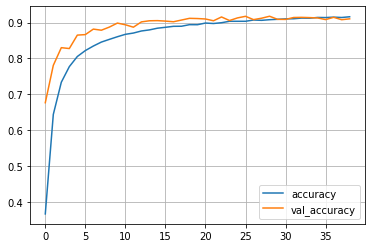

11005/1 - 2s - loss: 0.3496 - accuracy: 0.8999
 ~~~ simulation session ended ~~~


1000it [00:38, 26.29it/s]


n= 01000, nWrong= 00078, wer= 0.07800, acc= 0.92200
##########
a Real-time Test..., 
press 【Enter】and speak out within 1 sec      
the words are in the list of 35 words: 

###################
['_silence_', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'zero', 'yes', 'no', 'go', 'stop', 'on', 'off', 'up', 'down', 'left', 'right', 'forward', 'backward', 'marvin', 'sheila', 'dog', 'cat', 'bird', 'bed', 'happy', 'house', 'learn', 'follow', 'tree', 'visual', 'wow']
###################

PS: (you cannot say '_silence_', 
it just for "silence" 
or "no sound" 
or "background noise") 

press "q" to quit
or another key to record 1 sec speech...

y= 【yes】
press "q" to quit
or another key to record 1 sec speech...

y= 【no】
press "q" to quit
or another key to record 1 sec speech...

y= 【zero】
press "q" to quit
or another key to record 1 sec speech...

y= 【one】
press "q" to quit
or another key to record 1 sec speech...

y= 【go】
press "q" to quit
or another key to record 1 se

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Sat Dec 21 23:44:17 2019
@author: renyu

functionalKeras005_spchCmdNmelSpec.py
ryLab00.py

ryTrainModel03.py

"""
# In[]
#import ryPrepareDataset00

# In[]
import numpy as np
import time

basePath= '../ryDatasets/gscV2/'
fn= 'gscV2_data.npz'


t0= time.time()

z= np.load(basePath+fn)

x_train=    z['x_trainWithSil']    
y_train=    z['y_trainWithSil']    
x_val=      z['x_val']      
y_val=      z['y_val']
x_test=     z['x_test']     
y_test=     z['y_test']     

fnModel= 'ryModel.hdf5'

print(".... z= np.load({}) will train into {}".format(fn, fnModel))


# In[]
import tensorflow as tf

def ryFeature(x, 
           sample_rate= 16000, 
           
           frame_length= 1024,
           frame_step=    128,  # frame_length//2
           
           num_mel_bins=     128,
           lower_edge_hertz= 20,     # 0
           upper_edge_hertz= 16000/2, # sample_rate/2   
           
           mfcc_dim= 13
           ):
    
    stfts= tf.signal.stft(x, 
                          frame_length, #=  256, #1024, 
                          frame_step, #=    128,
                          #fft_length= 1024
                          pad_end=True
                          )
    
    spectrograms=     tf.abs(stfts)
    log_spectrograms= tf.math.log(spectrograms + 1e-10)
    
    # Warp the linear scale spectrograms into the mel-scale.
    num_spectrogram_bins= stfts.shape[-1]  #.value
    
    linear_to_mel_weight_matrix= tf.signal.linear_to_mel_weight_matrix(
          num_mel_bins, 
          num_spectrogram_bins, 
          sample_rate, 
          lower_edge_hertz,
          upper_edge_hertz)
    
    mel_spectrograms= tf.tensordot(
          spectrograms, 
          linear_to_mel_weight_matrix, 1)
    
    mel_spectrograms.set_shape(
          spectrograms.shape[:-1].concatenate(
              linear_to_mel_weight_matrix.shape[-1:]))
    
    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms= tf.math.log(mel_spectrograms + 1e-10)
    
    # Compute MFCCs from log_mel_spectrograms and take the first 13.
    mfccs= tf.signal.mfccs_from_log_mel_spectrograms(
          log_mel_spectrograms)[..., :mfcc_dim]
    
    feature= {'mfcc':               mfccs, 
              'log_mel_spectrogram':log_mel_spectrograms, 
              'log_spectrogram':    log_spectrograms, 
              'spectrogram':        spectrograms}
    
    return  feature


'''
batch_size= 1000  # 預防 gpu memory 不夠， 分批作業 
x= x_train[0:batch_size].astype(np.float32)
X= ryFeature(x)['log_mel_spectrogram']
X= X.numpy()
'''


# In[]

import time

import tensorflow as tf


def get_all_fearure(all_x, batch_size= 1000):
    t0= time.time()
    
    x= all_x.astype(np.float32)
    
    #batch_size= 1000  # 預防 gpu memory 不夠， 分批作業 
    
    i=0
    XL=[]
    while i < x.shape[0]:
        
        if i+batch_size<=x.shape[0]:
            xx= x[i:i+batch_size]
        else:
            xx= x[i:]
        
        XX= ryFeature(xx)
        X= XX['log_mel_spectrogram'] 
        #'log_spectrogram'] #'mfcc'] #'log_mel_spectrogram']
        
        X= X.numpy().astype(np.float32)
        
        i  += batch_size
        XL += [X]
    
    XL= np.concatenate(XL)
    print('XL.shape={}'.format(XL.shape))
    
    dt= time.time()-t0
    print('tf.signal.stft, 執行時間 dt= {}'.format(dt))
    
    '''
    XL.shape=(64721, 125, 129) # nTime= 16000/128, nFreq=256/2+1
    tf.signal.stft, dt= 8.066392660140991
    '''
    return XL
# In[]
print('.... get_all_fearure() .... ')

t0= time.time()

#X_testREAL= get_all_fearure(x_testREAL)
X_test=     get_all_fearure(x_test)
X_val=      get_all_fearure(x_val)
X_train=    get_all_fearure(x_train)

#t0= time.time()
dt= time.time()- t0
print('... get_all_fearure() ... dt(sec)= {:.3f}'.format(dt))

### get_all_fearure() ... dt(sec)= 36.128026723861694
### get_all_fearure() ... dt(sec)= 52.950


# In[]

nTime, nFreq= X_train[0].shape

zzz='''
nTime, nFreq= (125, 128)
'''

# In[]
def normalize(x, axis= None):   
    if axis== None:
        x= (x-x.mean())/x.std()
    else:
        x= (x-x.mean(axis= axis))/x.std(axis= axis)
    
    return x

# In[]
print('.... normalize() ....')

X_train= X_train.reshape(-1, nTime, nFreq, 1).astype('float32') 
X_val=   X_val.reshape(-1, nTime, nFreq, 1).astype('float32') 
X_test=  X_test.reshape( -1, nTime, nFreq, 1).astype('float32') 
#X_testREAL=  X_testREAL.reshape( -1, nTime, nFreq, 1).astype('float32') 

#'''  好像重複做了？！
X_train=     normalize(X_train)#, axis=0)  # normalized for the all set, many utterence
X_val=       normalize(X_val)#, axis=0)
X_test=      normalize(X_test)#, axis=0)
#X_testREAL=  normalize(X_testREAL)#, axis=0)
#'''

# In[]

import tensorflow as tf

tf.keras.backend.clear_session()  
# For easy reset of notebook state.

from tensorflow              import keras
from tensorflow.keras        import layers, Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import AveragePooling1D

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# In[]






# In[]
nCategs= len(set(y_train)) #36 #c_train.size #36


x= Input(shape= (nTime, nFreq, 1))

h= x


#'''
h= Conv2D(8,   (16,16), activation='relu', padding='same')(h)
h= MaxPooling2D((4,4), padding='same')(h)
h= Dropout(0.2)(h)

h= Conv2D(16,   (8,8), activation='relu', padding='same')(h)
h= MaxPooling2D((4,4), padding='same')(h)
h= Dropout(0.2)(h)

h= Flatten()(h)

h= Dense(256,  activation='relu')(h)
h= Dropout(0.2)(h)


h= Dense(nCategs,  activation='softmax')(h)

y= h

m= Model(inputs=  x, 
         outputs= y)

m.summary()



# In[]
#keras.utils.plot_model(m, 'm.png', show_shapes=True)



# In[]
m.compile(  
        loss=    'sparse_categorical_crossentropy',
        metrics= ['accuracy'])


es= EarlyStopping(
        monitor=   'val_loss', 
        min_delta= 1e-10,
        patience=  10, 
        mode=      'min', 
        verbose=   1) 



mc= ModelCheckpoint(fnModel, 
        monitor=    'val_accuracy', 
        verbose=    1, 
        save_best_only= True, 
        mode=      'max')

t0= time.time()

h= m.fit(X_train, y_train,
         
        batch_size=500, #1000, # 1000
        epochs=    100,
        
        callbacks=[es, mc],
        
        #validation_split= 0.1
        validation_data= (X_val, y_val)
        )


#t0= time.time()
dt= time.time()- t0
print('... h= m.fit() ... dt(sec)= {}'.format(dt))

# In[]
import numpy as np
from matplotlib import pyplot as pl
v0= h.history['accuracy']
v1= h.history['val_accuracy']
pl.plot(v0, label='accuracy')
pl.plot(v1, label='val_accuracy')
pl.legend()
pl.grid('on')
pl.show()
#keras.utils.plot_model(m, 'm.png', show_shapes=True)

# In[]


m.evaluate(X_test,      y_test,      verbose=2)


# In[]


# In[]

## for version.002

print(' ~~~ simulation session ended ~~~')

# In[]
import numpy as np
from tensorflow.keras.models import load_model
import sounddevice as sd

#import audioUtils


ryGscList=[ 
 '_silence_',
 'one',  'two', 'three', 'four', 'five',
 'six', 'seven', 'eight', 'nine', 'zero',
 'yes', 'no',
 'go', 'stop',
 'on', 'off',
 'up', 'down',
 'left', 'right',
 'forward', 'backward',
 'marvin', 'sheila',
 'dog', 'cat',
 'bird', 'bed',
 'happy', 'house',
 'learn', 'follow',
 'tree', 'visual',
 'wow'
 ]


labels= ryGscList


model= load_model(fnModel)


def predict(x):#, fs=16000):
    prob=  model.predict(x)#.reshape(1,fs,1))
    index= np.argmax(prob[0])
    y= labels[index]
    return y

def recWav(x, featureOut= False):
    x= x.flatten()    

    X= ryFeature(x)['log_mel_spectrogram']
    
    X= X.numpy().astype(np.float32)
    
    X= normalize(X)  # normalized for only one utterence x

    Xin= X.reshape(1,X.shape[0],X.shape[1], 1)
    y= predict(Xin)
    
    if featureOut == True:
        return y, X
    else:
        return y


# In[]
    
#import numpy as np
#from tensorflow.keras.models import load_model
import sounddevice as sd

import pylab as pl 
from tqdm import tqdm



n= 0
nWrong= 0 
wrongL= []

infoL= []
yL= []  
for x, yI in tqdm(zip(x_test[0:1000], y_test[0:1000])): #xL[0:10]:
    #x= x_testREAL[i]
    
    yAns= labels[yI]
    
    x= x.astype(np.float32)
    
    #sd.play(x, samplerate= 16000)
        
    y= recWav(x) #, featureOut=True) 
    
    yL += [y]
    # the acc will be slightly different because of different normalization base
    
    #info= 'n= {:05d}, nWrong= {:05d}, y=【{}】, yAns= [{}]'.format(
    #        n, nWrong, y, yAns)
    #print(info)
    
    
    if y != yAns:
        nWrong += 1
        wrongL += [n]
        
        info= '''n= {:05d}, nWrong= {:05d}, wer= {:.5f}, y=【{}】, yAns= [{}]'''.format(
                 n, nWrong, nWrong/(n+1), y, yAns)
        
        #print(info)
        
        infoL += [info]
        
        
        '''
        sd.play(x, samplerate= 16000)
        
        pl.subplot(2,1,1)
        
        pl.title(info)

        pl.imshow(X.transpose(), origin='low')
        
        pl.subplot(2,1,2)
        pl.plot(x)
        pl.grid('on')
        pl.show()
            
        sd.wait()
        '''
    
    n += 1
    #break
# In[]    
info= '''n= {:05d}, nWrong= {:05d}, wer= {:.5f}, acc= {:.5f}'''.format(
         n, nWrong, nWrong/n, 1-nWrong/n)

infoL += [info]

print(info)

fnInfo= 'infoL_test.txt'
#np.save(, np.array(infoL))
with open(fnInfo,'w') as fp:
    for info in infoL:
        print(info, file= fp)




# In[]

print('''##########
a Real-time Test..., 
press 【Enter】and speak out within 1 sec      
the words are in the list of 35 words: 

###################
{}
###################

PS: (you cannot say '_silence_', 
it just for "silence" 
or "no sound" 
or "background noise") 
'''.format(labels))


    
T=  1     # Duration of recording
fs= 16000  # Sample rate

xL= []
for i in range(100):
    
    aKey= input('{}\n{}\n'.format(
                'press "q" to quit', 
                'or another key to record 1 sec speech...'))
    if aKey=='q':
        print('~~~the end~~~')
        break
    
    x= sd.rec(int(T*fs), 
            samplerate= fs, 
            channels= 1, 
            dtype='float32')
        
    sd.wait()  # Wait until recording is finished
    
    y= recWav(x)
    
    print('y= 【{}】'.format(y))

    xL += [x]
    
    if y=='stop': break

# In[]
#import pickle
import compress_pickle as cpk

fn='rySp.gz'
cpk.dump(xL, fn)
xL= cpk.load(fn)

# In[]
    
print('... ry: Good Luck ...')



In [3]:
# -*- coding: utf-8 -*-
"""
Created on Sat Dec 21 23:44:17 2019
@author: renyu

functionalKeras005_spchCmdNmelSpec.py
ryLab00.py

ryLab01.py   ... 
ryLab01_1.py ...

ryRecog03.py ...

第一次用 CNN 做出 能辨識 35 個 英文詞 的 語音辨識系統 ...

"""
# In[]


# In[]
#
import time

import numpy as np

import tensorflow as tf

from tensorflow.keras.models import load_model

import sounddevice as sd


# In[]


def ryFeature(x, 
           sample_rate= 16000, 
           
           frame_length= 1024,
           frame_step=    128,  # frame_length//2
           
           num_mel_bins=     128,
           lower_edge_hertz= 20,     # 0
           upper_edge_hertz= 16000/2, # sample_rate/2   
           
           mfcc_dim= 13
           ):
    
    stfts= tf.signal.stft(x, 
                          frame_length, #=  256, #1024, 
                          frame_step, #=    128,
                          #fft_length= 1024
                          pad_end=True
                          )
    
    spectrograms=     tf.abs(stfts)
    log_spectrograms= tf.math.log(spectrograms + 1e-10)
    
    # Warp the linear scale spectrograms into the mel-scale.
    num_spectrogram_bins= stfts.shape[-1]  #.value
    
    linear_to_mel_weight_matrix= tf.signal.linear_to_mel_weight_matrix(
          num_mel_bins, 
          num_spectrogram_bins, 
          sample_rate, 
          lower_edge_hertz,
          upper_edge_hertz)
    
    mel_spectrograms= tf.tensordot(
          spectrograms, 
          linear_to_mel_weight_matrix, 1)
    
    mel_spectrograms.set_shape(
          spectrograms.shape[:-1].concatenate(
              linear_to_mel_weight_matrix.shape[-1:]))
    
    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms= tf.math.log(mel_spectrograms + 1e-10)
    
    # Compute MFCCs from log_mel_spectrograms and take the first 13.
    mfccs= tf.signal.mfccs_from_log_mel_spectrograms(
          log_mel_spectrograms)[..., :mfcc_dim]
    
    feature= {'mfcc':               mfccs, 
              'log_mel_spectrogram':log_mel_spectrograms, 
              'log_spectrogram':    log_spectrograms, 
              'spectrogram':        spectrograms}
    
    return  feature


# In[]
def normalize(x):   
    x= (x-x.mean())/x.std()
    return x



# In[]
def predict(x, withProb= False):#, fs=16000):
    global NNmodel, LabelDic

    prob=  NNmodel.predict(x)#.reshape(1,fs,1))
    index= np.argmax(prob[0])
    y= LabelDic[index]
    
    if withProb== True:
        probability= np.max(prob[0])
        
        #y='{} ({:.2f})'.format(y, probability)
        y= (y, probability)
    return y

def recWav(x, featureOut= False, withProb= False):
    x= x.flatten()    

    X= ryFeature(x)['log_mel_spectrogram']
    
    X= X.numpy().astype(np.float32)
    
    X= normalize(X)

    Xin= X.reshape(1,X.shape[0],X.shape[1], 1)
    y=   predict(Xin, withProb)
    
    if featureOut == True:
        return y, X
    else:
        return y





# In[]

def rec_long_wav(x= None, T=1, dt=.5, fs=16000, pauseByKey= False, fn= None):
    
    if pauseByKey==True:
        aKey= input('press a key to record speech...')
    
    if fn==None and x == None:
        x= sd.rec(int(T*fs), 
                samplerate= fs, 
                channels=   1, 
                dtype=      'float32')
            
        sd.wait()  # Wait until recording is finished
        
    elif fn != None:
        x= np.load(fn)
        #T= x.size/fs
    else:
        #T= x.size/fs
        print('x.shape= {}'.format(x.shape))
        pass
    
    T= x.size/fs
    if T==1:
        y= recWav(x)
    elif T>1:
        # 若輸入語音的長度 T > 1 (sec)，
        # 則移動音框 dt 切成一個一個 1 sec 的語音片段
        # 保持 T/dt 個輸出結果 (邊界之處仍有bug...)
        t=0
        yL= []
        while t<T-dt:
            
            if int((1+t)*fs)<=T*fs:
                x1sec= x[int(t*fs) : int(t*fs)+fs]
            else:
                x1sec= np.random.random(1*fs)*1e-10
                x1sec= x1sec.astype(np.float32)
                
                xx= x[int(t*fs): ].flatten()
                x1sec[0:xx.size]= xx 
            
            y= recWav(x1sec, withProb= True)
            yL += [y]
            t += dt
        y= np.array(yL)
    else:
        y= None
        pass
    
    print('y=【{}】'.format(y))
    
    return x, y


'''
LabelDic= {0: '_silence_', 
           1: 'nine', 2: 'yes', 3: 'no', 4: 'up', 5: 'down', 
           6: 'left', 7: 'right', 8: 'on', 9: 'off', 10: 'stop', 
           11: 'go', 12: 'zero', 13: 'one', 14: 'two', 15: 'three', 
           16: 'four', 17: 'five', 18: 'six', 19: 'seven', 20: 'eight', 
           21: 'backward', 22: 'bed', 23: 'bird', 24: 'cat', 25: 'dog', 
           26: 'follow', 27: 'forward', 28: 'happy', 29: 'house', 30: 'learn', 
           31: 'marvin', 32: 'sheila', 33: 'tree', 34: 'visual', 35: 'wow'}
'''

LabelDic= ryGscList=[ 
 '_silence_',
 'one',  'two', 'three', 'four', 'five',
 'six', 'seven', 'eight', 'nine', 'zero',
 'yes', 'no',
 'go', 'stop',
 'on', 'off',
 'up', 'down',
 'left', 'right',
 'forward', 'backward',
 'marvin', 'sheila',
 'dog', 'cat',
 'bird', 'bed',
 'happy', 'house',
 'learn', 'follow',
 'tree', 'visual',
 'wow'
 ]


#nCategs= len(LabelDic) #36 

tf.keras.backend.clear_session() 

#fnModel= 'ry_best_model1.hdf5'

fnModel= 'ryModel.hdf5'
 
NNmodel= load_model(fnModel)

if __name__=='__main__':
    timeDuration= 10 #sec
    input('press any to record a {} sec wav...'.format(
                timeDuration))
    
    # .... main recognition ....
    x, y= rec_long_wav(T=timeDuration, dt=.1)
    
    xyL= []
    while True:
        aKey= input('press "q" to quit, or any other to record a {} sec wav...'.format(
                timeDuration))
        if aKey == 'q': break
        
        x, y= rec_long_wav(T=timeDuration, dt=.1)
        
        xyL += (x, y)
    
    print('ry: Good Luck, Bye...')    




press any to record a 10 sec wav...
y=【[['dog' '0.47860655']
 ['yes' '0.99999785']
 ['yes' '1.0']
 ['yes' '1.0']
 ['yes' '1.0']
 ['yes' '1.0']
 ['yes' '1.0']
 ['yes' '1.0']
 ['yes' '1.0']
 ['yes' '1.0']
 ['no' '0.9987361']
 ['no' '0.99998724']
 ['no' '0.9987412']
 ['no' '0.9999801']
 ['no' '0.9999889']
 ['no' '0.9999999']
 ['no' '0.99999976']
 ['no' '0.99809104']
 ['no' '0.9922488']
 ['zero' '0.99616396']
 ['zero' '1.0']
 ['zero' '1.0']
 ['zero' '1.0']
 ['zero' '1.0']
 ['zero' '1.0']
 ['zero' '1.0']
 ['zero' '1.0']
 ['zero' '1.0']
 ['wow' '0.6419711']
 ['one' '1.0']
 ['one' '1.0']
 ['one' '1.0']
 ['one' '1.0']
 ['one' '1.0']
 ['one' '1.0']
 ['one' '1.0']
 ['one' '1.0']
 ['three' '0.9988471']
 ['two' '1.0']
 ['two' '1.0']
 ['two' '1.0']
 ['two' '1.0']
 ['two' '1.0']
 ['two' '1.0']
 ['two' '1.0']
 ['two' '1.0']
 ['six' '0.99998415']
 ['three' '0.9974051']
 ['three' '0.98385286']
 ['three' '0.9999976']
 ['three' '0.99999976']
 ['three' '1.0']
 ['three' '0.9996586']
 ['three' '0.9999975']
